# Table of Contents
 <p>

In [1]:
from __future__ import division, print_function, absolute_import
#import tensorflow as tf

# Latest version curve generation helper functions
import numpy as np
import scipy as sp
import math
from scipy.interpolate import splprep, splev
from multiprocessing import Process, Queue, Pool
import json

In [2]:



n_planar_curves_list = []
planar_curves_list = []


def add_noise(inputs, mean, std_dev):
    result = map(lambda x: x + np.random.normal(mean,std_dev,x.shape), inputs)
    return list(result)

#Step autoencoder
_debug_verbose = False 

class AutoEncoder(object):
    def __init__(self, arch):        
        self.num_layers = len(arch)
        self.input_layer_size = arch[0]
        self.output_layer_size = arch[-1]
        self.num_hidden_layers = len(arch)-2
        self.costs = []
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(arch[:-1], arch[1:])]        
        self.biases = [np.random.randn(y, 1) for y in arch[1:]]

    def getParams(self):
        #Get weights and biases unrolled into vector:
        params = [(x.ravel(), y.ravel()) for x, y in zip(self.weights, self.biases)]
        return params
    
    def forward(self, X):
        for b, w in zip(self.biases, self.weights):
            if (_debug_verbose): print("weights: ", w)
            if (_debug_verbose): print("biases: ", b)
            if (_debug_verbose): print("inputs :", X)
            if (_debug_verbose): print("dot product :", np.dot(w, X))
            #print("matrix dot product :", w.dot(X))
            X = self.unit_step(np.dot(w, X) + b)
            if (_debug_verbose): print("result :", X)
        return X.reshape(3,1)
    
    def unit_step(self, z):
        #return (lambda x: 0 if (x) < 0 else 1, z)[1]
        return z
    
    def unit_step_prime(self, z):
        return (1)

    def cost_function(self, X):
        self.yHat = self.forward(X)
        if (_debug_verbose): print ("squared error of X:{0} - Xhat:{1} is {2} & sum is {3}\n".format(X, self.yHat, ((X-self.yHat)**2), sum((X-self.yHat)**2)))
        J = 0.5*sum((X-self.yHat)**2)
        #self.costs.append(J) 
        return J
    
    def cost_derivative(self, output_activations, y):
        return (output_activations-y)   
    
    def cost_function_by_epoch(self, test_data, n_test):
        y_hat = [(self.forward(y)) for (y) in test_data[0:n_test]]
        y = [(y) for (y) in test_data[0:n_test]]
        #print([float(a[0][0]) for a in y])
        np.seterr( over='ignore' )
        #costs = []
        costs = [0.5*((a - b)**2) for a, b in zip(y, y_hat)]
        #costs.append([max(math.sqrt(0.5*(round(a[0][0],2) - round(b[0][0],2))**2),1000) for a, b in zip(y, y_hat)])
        #costs.append([0.5*math.sqrt((float(a[1][0]) - float(b[1][0]))**2) for a, b in zip(y, y_hat)])
        #costs.append([0.5*math.sqrt((float(a[2][0]) - float(b[2][0]))**2) for a, b in zip(y, y_hat)])
        self.costs.append(sum(costs)) #/n_test)
        #self.costs.append(sum(costs[:][:]))
        #self.costs.append([sum(costs[0]),sum(costs[1]),sum(costs[2])])
        if (_debug_verbose): print ("Total Cost {1} for Epoch {0} complete".format(len(self.costs), sum(self.costs[-1])))
        if (_debug_verbose): print ("Axis-wise Cost is {0} ".format((self.costs[-1])))
        return self.costs[-1]

 
    def GD(self, training_data, epochs, learning_rate, test_data=None):
        """Train the neural network using batch-wise 
        gradient descent. If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            np.random.shuffle(training_data)
            self.process_batch(training_data, learning_rate)
            if test_data:
                result = self.evaluate(test_data, n_test)
                if (_debug_verbose): print ("Epoch {0}: Score {1} / {2}".format(j, result, n_test))
            else:
                if (_debug_verbose): print ("Epoch {0} complete".format(j))

                        
    def process_batch(self, batch, learning_rate):
        """Update the network's weights by applying
        gradient descent using backpropagation to a single batch.
        """
        base_w = [np.zeros(w.shape) for w in self.weights]
        base_b = [np.zeros(b.shape) for b in self.biases]
        count=0
        for x in batch:
            delta_error_b , delta_error_w = self.backprop(x)
            updated_b = [nb+dnb for nb, dnb in zip(base_b, delta_error_b)]
            updated_w = [nw+dnw for nw, dnw in zip(base_w, delta_error_w)]
            count=count+1
        #print ("Process {0} inputs backprop ".format(count))    
            eta=learning_rate   
            self.weights = [w-(eta/len(batch))*nw
                        for w, nw in zip(self.weights, updated_w)]
            self.biases = [b-(eta/len(batch))*nb
                       for b, nb in zip(self.biases, updated_b)]
        
    def backprop(self, x):
        """Return ``( delta_w)`` representing the
        gradient for the cost function C_x. """
        
        if (_debug_verbose): print ("input: ", x)
        
        delta_w = [np.zeros(w.shape) for w in self.weights]
        delta_b = [np.zeros(b.shape) for b in self.biases]
        
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the activation (z) vectors, layer by layer
        
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = self.unit_step(z)
            activations.append(activation)
        
        if (_debug_verbose): print ("activations: ", activations)
        
        # backward pass
        delta = self.cost_derivative(activations[-1], x) *             self.unit_step_prime(zs[-1]) 
        delta_b[-1] = delta    
        delta_w[-1] = np.dot(delta, activations[-2].transpose())
        
        if (_debug_verbose): print ("cost derivative: ", self.cost_derivative(activations[-1], x))
        if (_debug_verbose): print ("unit step: ", self.unit_step_prime(zs[-1]))
        if (_debug_verbose): print("delta: ",delta)
        
        for l in range(2, self.num_layers):
            z = zs[-l]
            step1 = np.dot(self.weights[-l+1].transpose(), delta)
            delta = step1 * z
            delta_b[-l] = delta
            delta_w[-l] = np.dot(delta, activations[-l-1].transpose())
            if (_debug_verbose): print ("delta b updated: ", delta_b)
            if (_debug_verbose): print ("delta w updated:", delta_w)
            
        #print ("delta b: ", delta_b) 
        #print ("delta w:", delta_w)    
            
        return (delta_b, delta_w)

    def evaluate(self, test_data, n_test):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        self.cost_function_by_epoch(test_data, n_test)
        test_results = [self.forward(x)
                        for (x) in test_data]
        return sum(((x) - (x_hat))**2 for (x, x_hat) in zip(test_data, test_results))/n_test      
    
    def reconstruct(self, inputs):
        return [self.forward(x) for (x) in inputs]

In [8]:
import time
start = time.time()
def process_curves(curves_array):
    errors = []
    start = time.time()
    for i in range(len(curves_array[:])):
        print("Analysing curve [", i ,"]")
        start = time.time()
        Planar_Data = list(np.asarray(zip(curves_array[i][0], curves_array[i][1], curves_array[i][2])).reshape(300,3,1)) 
        ae = AutoEncoder([3,2,3])
        #print(Planar_Data)
        #print("AE params:", ae.getParams())
        ae.GD(Planar_Data, 500, 0.1, Planar_Data)
        #print("costs: ", ae.costs)
        print("error for this curve: ", errors)
        #scale errors
        scale=[curves_array[i][j].max() - curves_array[i][j].min() for j in [0,1,2]]
        #scaled_error = [ a[0]/b for a,b in zip(ae.costs[-1],scale)]
        #print("scaled error for this curve: ", scale,  scaled_error)
        #errors.append(scaled_error)
        errors.append(ae.costs[-1])
        planarity_errors = [sum(i[:][:]) for i in errors]
        print("\nTotal Sum Error: ", planarity_errors)
        end = time.time()
        print("Time spent in this curve: ", end - start)
    print(end - start)
    print(errors)
    return planarity_errors

data = {}
data['planar_curves_error'] = []
data['non_planar_curves_error'] = []



In [ ]:
#p_curve_data_1488329066.88168.json
#np_curve_data_1488329083.428903.json
data['planar_curves_error'] = []
with open('p_curve_data_cube_method_1489173944.8.json') as infile:
    c = json.load(infile)
    planar_curves_array = np.asarray(c['planar_curves'])
print("Planar curves read array shape: ", planar_curves_array.shape)
planar_errors = process_curves(planar_curves_array)
data['planar_curves_error'].append(np.asarray(planar_errors).tolist())

import os
os.system('say "your program has finished"')


Planar curves read array shape:  (100, 3, 300)
Analysing curve [ 0 ]
input:  [[-0.86733502]
 [-0.09135316]
 [ 1.02132887]]
activations:  [array([[-0.86733502],
       [-0.09135316],
       [ 1.02132887]]), array([[ 0.2718419 ],
       [ 0.24988635]]), array([[ 0.61081816],
       [ 0.63460069],
       [ 0.04982504]])]
cost derivative:  [[ 1.47815318]
 [ 0.72595385]
 [-0.97150382]]
unit step:  1
delta:  [[ 1.47815318]
 [ 0.72595385]
 [-0.97150382]]
delta b updated:  [array([[ 0.3482355 ],
       [-0.33421657]]), array([[ 1.47815318],
       [ 0.72595385],
       [-0.97150382]])]
delta w updated: [array([[-0.30203685, -0.03181241,  0.35566297],
       [ 0.28987773,  0.03053174, -0.34134503]]), array([[ 0.40182397,  0.36937031],
       [ 0.19734468,  0.18140596],
       [-0.26409545, -0.24276555]])]
input:  [[-0.75549339]
 [-0.01066178]
 [ 1.0795801 ]]
activations:  [array([[-0.75549339],
       [-0.01066178],
       [ 1.0795801 ]]), array([[ 0.31574717],
       [ 0.23894797]]), array([[ 

In [6]:
#p_curve_data_1488329066.88168.json
#np_curve_data_1488329083.428903.json
#np_curve_data_1488343211.03.json
#np_curve_data_1488818487.27.json
data['non_planar_curves_error'] = []
with open('np_curve_data_cube_method_1489680586.46.json') as infile:
    c = json.load(infile)
    n_planar_curves_array = np.asarray(c['non_planar_curves'])
print("Non-Planar curves read array shape: ", n_planar_curves_array.shape)
non_planar_errors = process_curves(n_planar_curves_array)
data['non_planar_curves_error'].append(np.asarray(non_planar_errors).tolist())

import os
os.system('say "your program has finished"')

Non-Planar curves read array shape:  (100, 3, 300)
Analysing curve [ 0 ]


ValueError: total size of new array must be unchanged

In [7]:
planar_curves_array.shape

(100, 3, 300)

In [8]:
n_planar_curves_array.shape

(100, 3, 300)

In [9]:
data

{'non_planar_curves_error': [], 'planar_curves_error': []}

In [126]:
import numpy.linalg as linalg

def get_eig(curves_array, dim=0):
    eig_vals = []
    eig_val_all = np.asarray(eig_vals)
    for i in  range(len(curves_array[:])): #range(5):# 
        #print("Analysing curve [", i ,"]")
        Planar_Data = np.stack([curves_array[i][0], curves_array[i][1], curves_array[i][2]])
        X = np.asmatrix(Planar_Data)
        cov = np.dot(X, X.T)
        #print(cov)
        eigvals, eigvecs = np.linalg.eig(cov)
        #print(eigvals) 
        #print(eigvecs)
        #print(curves_array[i][0].max() - curves_array[i][0].min(), curves_array[i][1].max() - curves_array[i][1].min(), 
        #      curves_array[i][2].max() - curves_array[i][2].min())
        eig_vals.append(eigvals)
        #print(eig_vals)
        eig_val_all = np.asarray(eig_vals)
        #print(eig_val_all)
        #print(eig_val_all.mean(axis=0))
        #print(eig_val_all[0].min(), eig_val_all[1].min(), eig_val_all[2].min())
    print("\nresult for this curve type:")    
    print("max x: ", eig_val_all[:,0].max()) #x-axis eig vals
    print("max y: ", eig_val_all[:,1].max()) #y-axis eig vals
    print("max z: ", eig_val_all[:,2].max()) #z-axis eig vals
    print("\nmin x: ", eig_val_all[:,0].min()) #x-axis eig vals
    print("min y: ", eig_val_all[:,1].min()) #y-axis eig vals
    print("min z: ", eig_val_all[:,2].min()) #z-axis eig vals
    
    id_x = np.argmax(eig_val_all[:,0])
    id_y = np.argmax(eig_val_all[:,1])
    id_z = np.argmax(eig_val_all[:,2])
    print("max x eig index: ", id_x, eig_val_all[id_x])
    print("max y eig index: ", id_y, eig_val_all[id_y])
    print("max z eig index: ", id_z, eig_val_all[id_z])

    return curves_array[np.argmax(eig_val_all[:,dim])]

np_curve_max_z = get_eig(n_planar_curves_array, 2)
p_curve_max_y = get_eig(planar_curves_array, 1)


result for this curve type:
max x:  279.289546994
max y:  222.282116465
max z:  177.681701965

min x:  17.3627592599
min y:  17.1771626207
min z:  12.7433243095
max x eig index:  75 [ 279.28954699   44.53676383   59.55753166]
max y eig index:  61 [  36.96145275  222.28211647  137.17591214]
max z eig index:  1 [  48.74830601  114.90389028  177.68170197]

result for this curve type:
max x:  279.525893792
max y:  288.655389538
max z:  288.54342177

min x:  20.6470824695
min y:  29.7560077383
min z:  19.6316009094
max x eig index:  75 [ 279.52589379  144.98003206   26.57703368]
max y eig index:  35 [  32.04798316  288.65538954  216.74396297]
max z eig index:  94 [  28.58243725  197.14672515  288.54342177]


#data with sphere method curves:

result for this curve type:
max x:  3805.2046182
max y:  127.247159963
max z:  126.154849705

min x:  278.484933828
min y:  1.8063522037
min z:  3.3759739062
max x eig index:  7 [  3.80520462e+03   1.80635220e+00   3.07602055e+01]
max y eig index:  20 [ 284.53631443  127.24715996   28.28667443]
max z eig index:  17 [ 285.71072293   26.16476143  126.15484971]

result for this curve type:
max x:  3270.91159061
max y:  87.8266785577
max z:  87.589329811

min x:  782.67793435
min y:  0.0261052780002
min z:  0.048089637192
max x eig index:  82 [  3.27091159e+03   9.59837613e-02   1.30581010e+00]
max y eig index:  71 [  1.58179617e+03   8.78266786e+01   1.39455457e-01]
max z eig index:  75 [  1.58960806e+03   8.97960957e-02   8.75893298e+01]



In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_curve(x_new, y_new, z_new):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.plot(pts[0], pts[1], pts[2], 'ro')
    ax.plot(x_new, y_new, z_new, 'b-')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.axis('equal')
    ax.set_autoscale_on(False)
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])
    ax.set_zlim([-3,3])
    plt.show()  
plot_curve(n_planar_curves_array[1][0], n_planar_curves_array[1][1], n_planar_curves_array[1][2])
plot_curve(planar_curves_array[1][0], planar_curves_array[1][1], planar_curves_array[1][2])

In [9]:
start = time.time()
with open('planarity_errors_' + str(start) + '.json', 'w') as outfile:
    json.dump(data, outfile)
    
print("Error file written: " + str(start))    

Error file written: 1489714415.76


In [10]:
with open('planarity_errors_1489714415.76.json') as infile:
    c = json.load(infile)
    np_errors = np.asarray(c['non_planar_curves_error'])
    p_errors = np.asarray(c['planar_curves_error'])

In [10]:
np_errors.shape

NameError: name 'np_errors' is not defined

In [12]:
p_errors.shape

(1, 100, 1)

In [13]:
NPE = np.insert(np_errors, 1, 1, axis=2)

In [14]:
PE = np.insert(p_errors, 1, 0, axis=2)

In [15]:
from sklearn.naive_bayes import GaussianNB

In [16]:
#New
X = np.concatenate((NPE, PE), axis=0)
X.shape

(2, 100, 2)

In [17]:
X = X.reshape(200,2)
X

array([[  1.32415033e+02,   1.00000000e+00],
       [  6.65332355e+01,   1.00000000e+00],
       [  6.03597358e+01,   1.00000000e+00],
       [  4.88972181e+01,   1.00000000e+00],
       [  1.91792930e+01,   1.00000000e+00],
       [  5.01188380e+01,   1.00000000e+00],
       [  4.03235786e+01,   1.00000000e+00],
       [  6.79566541e+01,   1.00000000e+00],
       [  2.88405140e+01,   1.00000000e+00],
       [  5.04334465e+01,   1.00000000e+00],
       [  2.58981557e+01,   1.00000000e+00],
       [  3.92187794e+01,   1.00000000e+00],
       [  6.44533493e+01,   1.00000000e+00],
       [  1.65418401e+02,   1.00000000e+00],
       [  3.38484516e+01,   1.00000000e+00],
       [  1.34711175e+02,   1.00000000e+00],
       [  4.26513832e+01,   1.00000000e+00],
       [  9.82172586e+00,   1.00000000e+00],
       [  2.54846770e+01,   1.00000000e+00],
       [  8.59944043e+01,   1.00000000e+00],
       [  7.14799466e+01,   1.00000000e+00],
       [  2.77116041e+01,   1.00000000e+00],
       [  

In [18]:
nan_idx = [i for i, x in enumerate(X) if (math.isnan(x[0]) == True)]
nan_idx

[]

In [19]:
X_cleaned = np.delete(X, nan_idx, axis=0)
X_cleaned

array([[  1.32415033e+02,   1.00000000e+00],
       [  6.65332355e+01,   1.00000000e+00],
       [  6.03597358e+01,   1.00000000e+00],
       [  4.88972181e+01,   1.00000000e+00],
       [  1.91792930e+01,   1.00000000e+00],
       [  5.01188380e+01,   1.00000000e+00],
       [  4.03235786e+01,   1.00000000e+00],
       [  6.79566541e+01,   1.00000000e+00],
       [  2.88405140e+01,   1.00000000e+00],
       [  5.04334465e+01,   1.00000000e+00],
       [  2.58981557e+01,   1.00000000e+00],
       [  3.92187794e+01,   1.00000000e+00],
       [  6.44533493e+01,   1.00000000e+00],
       [  1.65418401e+02,   1.00000000e+00],
       [  3.38484516e+01,   1.00000000e+00],
       [  1.34711175e+02,   1.00000000e+00],
       [  4.26513832e+01,   1.00000000e+00],
       [  9.82172586e+00,   1.00000000e+00],
       [  2.54846770e+01,   1.00000000e+00],
       [  8.59944043e+01,   1.00000000e+00],
       [  7.14799466e+01,   1.00000000e+00],
       [  2.77116041e+01,   1.00000000e+00],
       [  

In [20]:
nan_idx = [i for i, x in enumerate(X_cleaned) if (math.isnan(x[0]) == True)]
nan_idx

[]

In [21]:
import matplotlib.pyplot as plt
#import plotly.plotly as py
plt.plot(X[0:190], 'k-', lw=2)
plt.show()

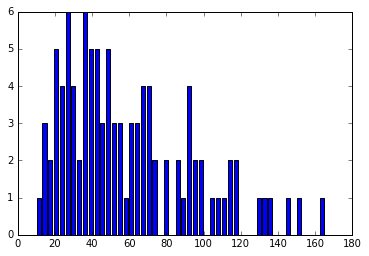

In [22]:
import matplotlib.pyplot as plt
import numpy as np
get_ipython().magic('matplotlib inline')

hist, bins = np.histogram(X_cleaned[0:100,0], bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()


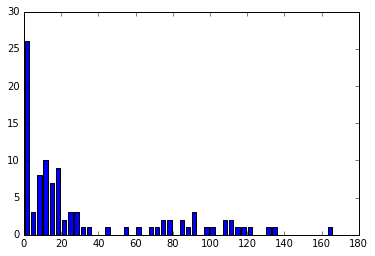

In [23]:
import matplotlib.pyplot as plt
import numpy as np
get_ipython().magic('matplotlib inline')

hist, bins = np.histogram(X_cleaned[100:200,0], bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()


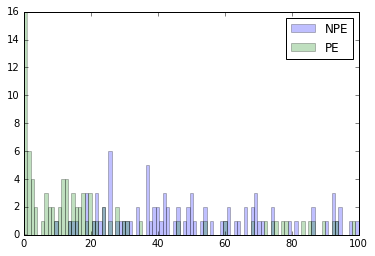

In [25]:
import random
import numpy
import matplotlib.pyplot as plt

bins = numpy.linspace(0, 100, 100)

plt.hist(X_cleaned[0:100,0], bins, alpha=0.25, label='NPE')
plt.hist(X_cleaned[100:198,0], bins, alpha=0.25, label='PE')
plt.legend(loc='upper right')
plt.show()

In [26]:
model = GaussianNB()

In [27]:
X_cleaned[:,0].shape

(200,)

In [28]:
model.fit(X_cleaned[:,0].reshape(200,1), X_cleaned[:,1])

GaussianNB(priors=None)

In [29]:
model.get_params()

{'priors': None}

In [30]:
predicted= model.predict_proba([[1.20092645e+02],[4.95902904e+02]])

In [31]:
predicted

array([[  2.88557388e-01,   7.11442612e-01],
       [  9.99999490e-01,   5.10052422e-07]])

In [32]:
X_cleaned.shape

(200, 2)

In [33]:
#new
np.random.shuffle(X_cleaned)
total = X_cleaned.shape[0]
num_batches = 5
batch_size = int(total/num_batches)
X_usable = X_cleaned[0:int(num_batches*batch_size)]
X_all = X_usable.reshape(num_batches, batch_size, 2)
X_all.shape

(5, 40, 2)

In [34]:
#new
from sklearn.linear_model import LogisticRegression
import random

for v_idx, v_data in enumerate(X_all):
    print("batch index: ", v_idx)
    indices = [0,1,2,3,4]
    indices.remove(v_idx)
    print("test set: ", indices)
    n = X_all.shape[1]
    print("n=", n)
    X_test = np.asarray([X_all[i,:,:] for i in indices]).reshape(4*n,2)
    print("X test shape: ", X_test.shape)
    model = GaussianNB()
    model.fit(X_test[:,0].reshape(4*n,1), X_test[:,1].reshape(4*n))

    #print(v_data.shape)
    #print(v_data)
    predicted= model.predict_proba(v_data[:,0].reshape(n,1))
    #print(predicted)
    
    for i in range(n):
        print("validation data: ", v_data[i][1], "predicted: ", predicted[i].argmax())
    
    score = sum([v_data[i][1] == predicted[i].argmax() for i in range(n)])
    print("num correct: ",  score, "\npercent correct: ", (score/n)*100)
    scores = model.score(v_data[:,0].reshape(n,1), v_data[:,1], sample_weight=None)
    print("self reported score: ", scores)
    
    model1 = LogisticRegression()
    mdl = model1.fit(X_test[:,0].reshape(4*n,1), X_test[:,1].reshape(4*n))
    w = model1.coef_[0]
    print("w:", w)
    
    #xx = np.linspace(0,5000)
    #yy = a * xx - (model1.intercept_[0])/w[1]
    #plt.plot(xx,yy,'k-')
    
    
    #xx, yy = np.mgrid[1:5000:100, 1:5000:100]
    #grid = np.c_[xx.ravel(), yy.ravel()]
    #probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)


    #correct = [predicted[i]==v_data[1][i] for i in range(n)]
    #print(sum(correct)/n)
    #from matplotlib import pyplot as plt
    #ax = plt.gca()
    #cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    #ax.scatter(, df.income, c=(df.default == 'Yes'), cmap=cm_bright)        

batch index:  0
test set:  [1, 2, 3, 4]
n= 40
X test shape:  (160, 2)
validation data:  0.0 predicted:  0
validation data:  0.0 predicted:  1
validation data:  0.0 predicted:  0
validation data:  1.0 predicted:  1
validation data:  0.0 predicted:  0
validation data:  1.0 predicted:  0
validation data:  0.0 predicted:  0
validation data:  1.0 predicted:  1
validation data:  0.0 predicted:  1
validation data:  0.0 predicted:  1
validation data:  0.0 predicted:  0
validation data:  1.0 predicted:  1
validation data:  0.0 predicted:  0
validation data:  1.0 predicted:  1
validation data:  1.0 predicted:  1
validation data:  1.0 predicted:  1
validation data:  0.0 predicted:  1
validation data:  0.0 predicted:  1
validation data:  0.0 predicted:  1
validation data:  0.0 predicted:  0
validation data:  1.0 predicted:  0
validation data:  0.0 predicted:  0
validation data:  1.0 predicted:  1
validation data:  0.0 predicted:  1
validation data:  1.0 predicted:  1
validation data:  0.0 predicte

In [12]:
(65+70+72.57+77.5+62.5)/5

69.514

from sklearn.linear_model import LogisticRegression
import random

for v_idx, v_data in enumerate(zip(X_all, Y_all)):
    #print("v idx: ", v_idx)
    indices = [0,1,2,3,4]
    indices.remove(v_idx)
    #print("test set: ", indices)
    n = 2*19
    X_test = np.asarray([X_all[i,:,:] for i in indices]).reshape(4*n,1)
    Y_test = np.asarray([Y_all[i,:] for i in indices]).reshape(4*n)
    #print(X_test.shape)
    nums = [x for x in range(4*n)]
    random.shuffle(nums)
    #print(nums)
    model = GaussianNB()
    #print(Y_test[nums])
    #print(sum(Y_test)/(4*n))
    model.fit(X_test[nums], Y_test[nums])
    #print(v_data[1])
    #print(p_data.shape)
    predicted= model.predict_proba(v_data[0])
    #print(predicted)
    scores = model.score(v_data[0], v_data[1], sample_weight=None)
    print(scores)
    
    model1 = LogisticRegression()
    mdl = model1.fit(X_test[nums], Y_test[nums])
    w = model1.coef_[0]
    #a = -w[0]/w[1]
    #xx = np.linspace(0,5000)
    #yy = a * xx - (model1.intercept_[0])/w[1]
    #plt.plot(xx,yy,'k-')
    
    
    #xx, yy = np.mgrid[1:5000:100, 1:5000:100]
    #grid = np.c_[xx.ravel(), yy.ravel()]
    #probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)


    #correct = [predicted[i]==v_data[1][i] for i in range(n)]
    #print(sum(correct)/n)
    #from matplotlib import pyplot as plt
    #ax = plt.gca()
    #cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    #ax.scatter(, df.income, c=(df.default == 'Yes'), cmap=cm_bright)        

from sklearn.naive_bayes import BernoulliNB

for v_idx, v_data in enumerate(zip(X_all, Y_all)):
    #print("v idx: ", v_idx)
    indices = [0,1,2,3,4]
    indices.remove(v_idx)
    #print("test set: ", indices)
    n = 2*19
    X_test = np.asarray([X_all[i,:,:] for i in indices]).reshape(4*n,1)
    Y_test = np.asarray([Y_all[i,:] for i in indices]).reshape(4*n)
    #print(X_test.shape)
    nums = [x for x in range(4*n)]
    random.shuffle(nums)
    #print(nums)
    model = BernoulliNB()
    #print(Y_test[nums])
    #print(sum(Y_test)/(4*n))
    model.fit(X_test[nums], Y_test[nums])
    #print(v_data[1])
    #print(p_data.shape)
    predicted= model.predict_proba(v_data[0])
    #print(predicted)
    scores = model.score(v_data[0], v_data[1], sample_weight=None)
    print(scores)
    #correct = [predicted[i]==v_data[1][i] for i in range(n)]
    #print(sum(correct)/n)

from sklearn.naive_bayes import MultinomialNB
import random
for v_idx, v_data in enumerate(zip(X_all, Y_all)):
    #print("v idx: ", v_idx)
    indices = [0,1,2,3,4]
    indices.remove(v_idx)
    #print("test set: ", indices)
    n = X_all.shape[1] 
    X_test = np.asarray([X_all[i,:,:] for i in indices]).reshape(4*n,1)
    Y_test = np.asarray([Y_all[i,:] for i in indices]).reshape(4*n)
    #print(X_test.shape)
    nums = [x for x in range(4*n)]
    random.shuffle(nums)
    #print(nums)
    model = MultinomialNB()
    #print(Y_test[nums])
    model.fit(X_test[nums], Y_test[nums])
    #print(v_data[0])
    predicted= model.predict(v_data[0])
    #print(predicted)
    correct = [predicted[i]==v_data[1][i] for i in range(n)]
    print(sum(correct)/n)

In [86]:
%matplotlib qt 
%matplotlib notebook 

In [11]:
import numpy.linalg as linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
#ax1 = fig.add_subplot(221, projection='3d')   
#ax2 = fig.add_subplot(222, projection='3d')   
#ax3 = fig.add_subplot(223, projection='3d')   


#planar_curves_array - from file
#n_planar_curves_array - from file

def get_eig(curves_array, dim=0):
    eig_vals = []
    eig_val_all = np.asarray(eig_vals)
    eig_vecs = []
    eig_vec_all = np.asarray(eig_vecs)
    for i in  range(1):# range(len(curves_array[:])): # 
        fig = plt.figure()
        #ax = fig.add_subplot(111, projection='3d')
        ax1 = fig.add_subplot(221, projection='3d')   
        ax2 = fig.add_subplot(222, projection='3d')   
        ax3 = fig.add_subplot(223, projection='3d')   
    
        print("\nAnalysing curve [", i ,"]")
        Planarity_Data = np.stack([curves_array[i][0], curves_array[i][1], curves_array[i][2]])
        ax1.plot(curves_array[i][0], curves_array[i][1], curves_array[i][2], 'ro')
        #plt.show()
        
        X = np.asmatrix(Planarity_Data)
        mu = np.mean(X, axis=0)
        #print("mu: ",mu)
        print("Shape of X matrix containing all points: ", X.shape)
        cov = np.dot(X, X.T)
        #print("Cov\n", cov)
        eigvals, eigvecs = np.linalg.eig(cov)
        eig_pairs = [(np.abs(eigvals[i]), eigvecs[:,i]) for i in range(len(eigvals))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        
        #for i in eig_pairs:
        #    print("eig vals: ", i[0])
        
        for i in [0,1,2]:
            #print("pairs: ", eigvals[i], eigvecs[:,i])
            v = eigvecs[:,i].reshape(1,3).T
            #print(v)
            lhs = np.dot(cov,v)
            #print(lhs)
            rhs = np.dot(eigvals[i],v)
            #print(rhs)
            
        matrix_w = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))
        print('Matrix W:\n', matrix_w)
        print('Shape of transformation matrix W: ', matrix_w.shape)

        transformed = matrix_w.T.dot(X)
        print("Transformed matrix shape: ", transformed.shape)
        ax2.plot(transformed[0], transformed[1], 'ro') 
        #plt.show()
        #plt.clf()
        
        #reconstruct from eig vectors
        recoverd = matrix_w.dot(transformed)
        
        print("Recovered matrix shape: ", recoverd.shape)
        recoverd += mu
        ax3.plot(recoverd[0], recoverd[1], recoverd[2], 'ro') 
        
        plt.show()
        
        plt.clf()
        
        eig_vals.append(eigvals)
        eig_vecs.append(eigvecs)
        eig_val_all = np.asarray(eig_vals)
        eig_vec_all = np.asarray(eig_vecs)
        
    
    return 
np_curve_max_z = get_eig(n_planar_curves_array)
p_curve_max_y = get_eig(planar_curves_array)


Analysing curve [ 0 ]
Shape of X matrix containing all points:  (3, 300)
Matrix W:
 [[ 0.62467872  0.01821941]
 [ 0.11749009  0.98615433]
 [-0.7719926   0.16482624]]
Shape of transformation matrix W:  (3, 2)
Transformed matrix shape:  (2, 300)
Recovered matrix shape:  (3, 300)


KeyboardInterrupt: 


Analysing curve [ 0 ]
Shape of X matrix containing all points:  (3, 300)
Matrix W:
 [[ 0.07260732 -0.86084384]
 [-0.657978    0.33816634]
 [ 0.74952861  0.38025177]]
Shape of transformation matrix W:  (3, 2)
Transformed matrix shape:  (2, 300)
Recovered matrix shape:  (3, 300)


In [15]:
import numpy as np
import sklearn.datasets, sklearn.decomposition
import numpy.linalg as linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def pca_err(curves_array):
    errors=[]
    for i in range(len(curves_array[:])):  
        #fig = plt.figure()
        #ax1 = fig.add_subplot(221, projection='3d')   
        #ax2 = fig.add_subplot(222, projection='3d')   
        #ax3 = fig.add_subplot(223, projection='3d')   

        X = curves_array[i].T #sklearn.datasets.load_iris().data
        mu = np.mean(X, axis=0)
        print("X: ", X.shape)
        #print("mu: ", mu)
        pca = sklearn.decomposition.PCA()
        pca.fit(X)

        #ax1.plot(curves_array[i][0], curves_array[i][1], curves_array[i][2], 'ro') 

        nComp = 2
        print("Transfomed: ", pca.transform(X)[:,:nComp].shape)
        print("EV: ", pca.components_[:,:][:,:nComp])

        transformed = pca.transform(X)[:,:nComp].T
        #ax2.plot(transformed[0], transformed[1], 'ro') 

        Xhat = np.dot(pca.transform(X)[:,:nComp], pca.components_[:nComp,:])
        Xhat += mu

        reconstructed_curve = Xhat.T
        #ax3.plot(reconstructed_curve[0], reconstructed_curve[1], reconstructed_curve[2], 'ro') 

        
        #print(Xhat.shape)
        #plt.show()
        
        err = 0.5*sum((X-Xhat)**2)
        errors.append(sum(err))
        
        print("Err: ", err)
        
    return np.asarray(errors)

np_pca_err = pca_err(n_planar_curves_array)
p_pca_err = pca_err(planar_curves_array)

X:  (300, 3)
Transfomed:  (300, 2)
EV:  [[-0.62260335 -0.07118286]
 [-0.04511575 -0.99093258]
 [ 0.78123597 -0.1139545 ]]
Err:  [ 8.19987967  0.17446406  5.0608218 ]
X:  (300, 3)
Transfomed:  (300, 2)
EV:  [[-0.11679272  0.80448543]
 [ 0.80302158  0.42153752]
 [-0.58439353  0.41846064]]
Err:  [  7.08411661   3.63232025  10.02672242]
X:  (300, 3)
Transfomed:  (300, 2)
EV:  [[-0.22782555  0.48373054]
 [ 0.12924294  0.87521179]
 [-0.96508641  0.003014  ]]
Err:  [  2.01891927e+01   1.96912536e-04   1.48698024e+00]
X:  (300, 3)
Transfomed:  (300, 2)
EV:  [[-0.74492891 -0.44301582]
 [-0.63872372  0.25769023]
 [ 0.19264717 -0.85868081]]
Err:  [  1.57132615  31.21796383   9.54975516]
X:  (300, 3)
Transfomed:  (300, 2)
EV:  [[-0.84041088  0.11203411]
 [ 0.5018057  -0.20868062]
 [ 0.20469633  0.97154555]]
Err:  [  0.76846306  17.31128212   0.26040547]
X:  (300, 3)
Transfomed:  (300, 2)
EV:  [[ 0.60650149 -0.67754428]
 [ 0.3432346  -0.24887787]
 [-0.71717917 -0.6920936 ]]
Err:  [ 6.84525373  6.37

In [20]:
import random
import numpy
import matplotlib.pyplot as plt

bins = numpy.linspace(0, 100, 100)

plt.hist(np_pca_err, bins, alpha=0.25, label='NPE')
plt.hist(p_pca_err, bins, alpha=0.25, label='PE')
plt.legend(loc='upper right')
plt.show()